# 样式迁移

## 阅读内容和风格图像

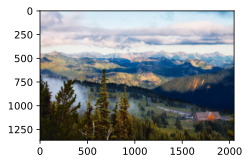

In [3]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('../img/rainier.jpg')
d2l.plt.imshow(content_img);

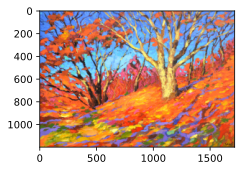

In [4]:
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

## 预处理和后处理

In [8]:
# 定义全局变量 rgb_mean 和 rgb_std，分别表示 RGB 三个通道的均值和标准差
# 这些值是在大规模图像数据集（如 ImageNet）上统计得到的，用于图像归一化操作
# 归一化可以使模型在不同数据集上具有更好的泛化能力
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

# 定义 preprocess 函数，用于对输入的图像进行预处理，使其适合输入到深度学习模型中
def preprocess(img, image_shape):
    # 使用 torchvision.transforms.Compose 组合多个图像变换操作
    # 它会按顺序依次对图像进行这些变换
    transforms = torchvision.transforms.Compose([
        # 将输入图像的大小调整为指定的 image_shape
        # 深度学习模型通常对输入图像的大小有固定要求
        torchvision.transforms.Resize(image_shape),
        # 将输入的 PIL 图像或 NumPy 数组转换为 torch.Tensor 类型
        # 并将像素值从 [0, 255] 范围缩放到 [0, 1] 范围
        torchvision.transforms.ToTensor(),
        # 对图像进行归一化处理
        # 公式为：output[channel] = (input[channel] - mean[channel]) / std[channel]
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    # 对输入图像 img 应用上述定义的所有变换操作
    # 并在张量的第 0 个维度上添加一个维度
    # 将图像的形状从 (C, H, W) 变为 (1, C, H, W)，以满足大多数深度学习模型对输入批量的要求
    return transforms(img).unsqueeze(0)

# 定义 postprocess 函数，用于对模型输出的图像进行后处理
# 将其转换为适合显示或保存的 PIL 图像
def postprocess(img):
    # 从批量中取出第一张图像
    # 因为在预处理时添加了批量维度，所以这里需要去除
    # 同时将图像移动到与 rgb_std 相同的设备（如 CPU 或 GPU）上，确保后续计算的兼容性
    img = img[0].to(rgb_std.device)
    # 将图像的通道维度从第 0 维移动到第 2 维
    # 将形状从 (C, H, W) 变为 (H, W, C)，这是 PIL 图像的常见格式
    # 对归一化后的图像进行反归一化操作，将像素值恢复到原始范围
    # 使用 torch.clamp 将像素值限制在 [0, 1] 范围内，防止出现超出范围的值
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    # 将图像的通道维度再次移动到第 0 维
    # 将形状从 (H, W, C) 变回 (C, H, W)，因为 ToPILImage 要求输入的张量形状为 (C, H, W)
    # 使用 torchvision.transforms.ToPILImage 将 torch.Tensor 类型的图像转换为 PIL 图像
    # 方便后续的显示或保存操作
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

## 抽取图像特征

In [11]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

C:\Users\29229\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\29229\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\29229/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [02:08<00:00, 4.46MB/s]


为了抽取图像的内容特征和风格特征，我们可以选择VGG网络中某些层的输出。 一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。 为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，即内容层，来输出图像的内容特征。 我们还从VGG中选择不同层的输出来匹配局部和全局的风格，这些图层也称为风格层。 正如 :numref:sec_vgg中所介绍的，VGG网络使用了5个卷积块。 实验中，我们选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层。 这些层的索引可以通过打印pretrained_net实例获取。

In [13]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

使用VGG层抽取特征时，我们只需要用到从输入层到最靠近输出层的内容层或风格层之间的所有层。 下面构建一个新的网络net，它只保留需要用到的VGG的所有层。

In [14]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [16]:
#给定输入X，如果我们简单地调用前向传播net(X)，只能获得最后一层的输出。 由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和风格层的输出。

def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

下面定义两个函数：get_contents函数对内容图像抽取内容特征； get_styles函数对风格图像抽取风格特征。 因为在训练时无须改变预训练的VGG的模型参数，所以我们可以在训练开始之前就提取出内容特征和风格特征。 由于合成图像是风格迁移所需迭代的模型参数，我们只能在训练过程中通过调用extract_features函数来抽取合成图像的内容特征和风格特征。

In [18]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## 定义损失函数

In [20]:
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

In [21]:
# 定义 gram 函数，用于计算输入特征图的格拉姆矩阵（Gram Matrix）
# 格拉姆矩阵常用于风格迁移任务中，它可以用来表示特征图的风格信息
def gram(X):
    # 计算输入特征图 X 的通道数
    # X.shape[1] 表示特征图的第二个维度，通常为通道数
    num_channels = X.shape[1]
    # 计算每个通道的元素数量
    # X.numel() 表示特征图 X 的总元素数量
    # X.numel() // X.shape[1] 即总元素数量除以通道数，得到每个通道的元素数量
    n = X.numel() // X.shape[1]
    # 将特征图 X 进行形状重塑
    # 把特征图从原始形状转换为 (num_channels, n) 的二维矩阵
    # 这样每个通道的数据就变成了矩阵的一行
    X = X.reshape((num_channels, n))
    # 计算格拉姆矩阵
    # torch.matmul(X, X.T) 计算特征图矩阵 X 与其转置 X.T 的矩阵乘法
    # 然后将结果除以通道数和每个通道元素数量的乘积 (num_channels * n) 进行归一化
    return torch.matmul(X, X.T) / (num_channels * n)

# 定义 style_loss 函数，用于计算风格损失
# 风格损失用于衡量生成图像的风格与目标风格图像的风格之间的差异
def style_loss(Y_hat, gram_Y):
    # 计算生成图像 Y_hat 的格拉姆矩阵
    # 通过调用 gram 函数得到生成图像的风格表示
    gram_Y_hat = gram(Y_hat)
    # 对目标风格图像的格拉姆矩阵进行分离操作
    # detach() 方法用于切断计算图，防止在反向传播时对目标风格图像的格拉姆矩阵进行更新
    gram_Y = gram_Y.detach()
    # 计算生成图像格拉姆矩阵与目标风格图像格拉姆矩阵的差值的平方
    # torch.square 用于计算每个元素的平方
    loss = torch.square(gram_Y_hat - gram_Y)
    # 计算损失的均值
    # 对差值平方后的矩阵求均值，得到最终的风格损失
    return loss.mean()

### 全变分损失

有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。
一种常见的去噪方法是*全变分去噪*（total variation denoising）：
假设$x_{i, j}$表示坐标$(i, j)$处的像素值，降低全变分损失

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$

能够尽可能使邻近的像素值相似。

In [30]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

损失函数：风格转移的损失函数是内容损失、风格损失和总变化损失的加权和

In [32]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## 初始化合成图像

In [37]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [39]:
# 定义 get_inits 函数，用于初始化风格迁移所需的参数
# 该函数会创建一个合成图像对象，将其初始化为输入图像，
# 并准备好优化器和目标风格图像的格拉姆矩阵
def get_inits(X, device, lr, styles_Y):
    # 创建一个 SynthesizedImage 类的实例 gen_img，用于合成图像
    # X.shape 表示输入图像 X 的形状，将其作为参数传递给 SynthesizedImage 类
    # .to(device) 将合成图像对象移动到指定的设备（如 CPU 或 GPU）上
    gen_img = SynthesizedImage(X.shape).to(device)
    # 将合成图像的权重数据初始化为输入图像 X 的数据
    # 这样合成图像的初始状态就和输入图像相同
    gen_img.weight.data.copy_(X.data)
    # 创建一个 Adam 优化器 trainer，用于更新合成图像的参数
    # gen_img.parameters() 表示合成图像需要优化的参数
    # lr 是学习率，控制优化过程中参数更新的步长
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    # 计算目标风格图像列表 styles_Y 中每个图像的格拉姆矩阵
    # 通过列表推导式遍历 styles_Y 中的每个图像 Y，调用 gram 函数计算其格拉姆矩阵
    # 最终得到一个包含所有目标风格图像格拉姆矩阵的列表 styles_Y_gram
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    # 返回合成图像、目标风格图像的格拉姆矩阵列表以及优化器
    # gen_img() 调用合成图像对象的 __call__ 方法，返回合成图像的张量
    return gen_img(), styles_Y_gram, trainer

## 训练模型

In [45]:
# 定义 train 函数，用于执行风格迁移的训练过程
# 参数解释：
# X: 输入的内容图像
# contents_Y: 内容特征目标值
# styles_Y: 风格图像列表
# device: 训练使用的设备（如 CPU 或 GPU）
# lr: 学习率
# num_epochs: 训练的总轮数
# lr_decay_epoch: 学习率衰减的间隔轮数
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    # 调用 get_inits 函数进行初始化
    # 得到合成图像 X、目标风格图像的格拉姆矩阵列表 styles_Y_gram 和优化器 trainer
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    # 创建学习率调度器 scheduler
    # 使用 StepLR 调度器，每经过 lr_decay_epoch 轮训练，学习率乘以 0.8 进行衰减
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    # 创建动画绘制器 animator，用于可视化训练过程中的损失变化
    # xlabel 为 x 轴标签，ylabel 为 y 轴标签
    # xlim 设定 x 轴的范围，legend 为图例
    # ncols 表示子图的列数，figsize 为图形的大小
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    # 开始训练循环，遍历 num_epochs 轮
    for epoch in range(num_epochs):
        # 清空优化器中的梯度信息
        # 避免梯度累积对后续训练的影响
        trainer.zero_grad()
        # 调用 extract_features 函数，从合成图像 X 中提取内容特征和风格特征
        # content_layers 和 style_layers 应该是预先定义好的用于提取内容和风格特征的层
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        # 调用 compute_loss 函数计算损失
        # 包括内容损失 contents_l、风格损失 styles_l、总变差损失 tv_l 和总损失 l
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        # 执行反向传播，计算梯度
        l.backward()
        # 根据计算得到的梯度，使用优化器更新合成图像的参数
        trainer.step()
        # 调用学习率调度器的 step 方法，更新学习率
        scheduler.step()
        # 每 10 轮训练进行一次可视化操作
        if (epoch + 1) % 10 == 0:
            # 在动画绘制器的第二个子图中显示经过后处理的合成图像
            animator.axes[1].imshow(postprocess(X))
            # 将当前轮次的内容损失、风格损失和总变差损失添加到动画绘制器中进行可视化
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    # 训练结束后，返回最终的合成图像
    return X

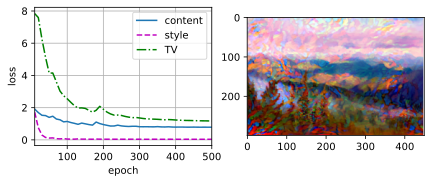

In [44]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)